In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:

holidays_events = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
transactions = pd.read_csv('transactions.csv')

sample_submission = pd.read_csv('sample_submission.csv')

In [109]:
holidays_events.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [110]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [111]:
oil.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [112]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [113]:
stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [114]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [115]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [116]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [117]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [118]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [119]:
transactions.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

In [120]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [121]:
sample_submission.columns

Index(['id', 'sales'], dtype='object')

In [122]:
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


# **combine all columns on one dataset**

In [123]:
#convert all columns to the date columns to datetime to merge the data
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
holidays_events["date"] = pd.to_datetime(holidays_events.date)
oil["date"] = pd.to_datetime(oil.date)

In [124]:
train['onpromotion'] = train['onpromotion'].astype("float16")
test['onpromotion'] = test['onpromotion'].astype("float16")
train['sales'] = train['sales'].astype("float32")
stores['cluster'] = stores['cluster'].astype("int8")

In [125]:
def merge_with_lagged_features(df, oil, holidays):
    # Create lagged oil prices
    oil_lag = oil.copy()
    oil_lag['date'] = oil_lag['date'] + pd.DateOffset(days=7)
    oil_lag.rename(columns={'oil_price': 'oil_price_lag_7'}, inplace=True)
    
    # Merge lagged oil and holidays
    df = df.merge(oil_lag, on='date', how='left')
    df = df.merge(holidays, on='date', how='left')
    return df

train1 = merge_with_lagged_features(train, oil, holidays_events)
test = merge_with_lagged_features(test, oil, holidays_events)
train1 = train1.merge(stores, on='store_nbr', how='left')
train1 = train1.merge(transactions, on=['date', 'store_nbr'], how='left')
train1 = train1.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})

In [126]:
def temporal_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    df['day_of_week'] = df['date'].dt.day_name()
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_weekend'] = (df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['dayofweek'] = df['date'].dt.dayofweek
    # Make sure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Sp lit into separate columns
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    
    return df          

train1 = temporal_features(train1)
test = temporal_features(test)

In [127]:
train1

c:\Users\ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning:

overflow encountered in cast

c:\Users\ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning:

overflow encountered in cast



,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,week,quarter,day_of_week,day_of_month,day_of_year,is_weekend,is_month_start,is_month_end,dayofweek,day
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
1,1,2013-01-01,1,BABY CARE,0.000000,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
2,2,2013-01-01,1,BEAUTY,0.000000,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
3,3,2013-01-01,1,BEVERAGES,0.000000,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
4,4,2013-01-01,1,BOOKS,0.000000,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.132996,0.0,49.07,Holiday,Local,Riobamba,...,33,3,Tuesday,15,227,0,0,0,1,15
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1.0,49.07,Holiday,Local,Riobamba,...,33,3,Tuesday,15,227,0,0,0,1,15
3054345,3000885,2017-08-15,9,PRODUCE,2419.729004,148.0,49.07,Holiday,Local,Riobamba,...,33,3,Tuesday,15,227,0,0,0,1,15
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8.0,49.07,Holiday,Local,Riobamba,...,33,3,Tuesday,15,227,0,0,0,1,15


In [ ]:
train1.describe()


In [91]:
train1.head()

c:\Users\ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning:

overflow encountered in cast

c:\Users\ali\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning:

overflow encountered in cast



,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,week,quarter,day_of_week,day_of_month,day_of_year,is_weekend,is_month_start,is_month_end,dayofweek,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1
4,4,2013-01-01,1,BOOKS,0.0,0.0,NaN,Holiday,National,Ecuador,...,1,1,Tuesday,1,1,0,1,0,1,1


In [92]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 29 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   date            datetime64[ns]
 2   store_nbr       int64         
 3   family          object        
 4   sales           float32       
 5   onpromotion     float16       
 6   dcoilwtico      float64       
 7   holiday_type    object        
 8   locale          object        
 9   locale_name     object        
 10  description     object        
 11  transferred     object        
 12  city            object        
 13  state           object        
 14  store_type      object        
 15  cluster         int8          
 16  transactions    float64       
 17  year            int32         
 18  month           int32         
 19  week            UInt32        
 20  quarter         int32         
 21  day_of_week     object        
 22  day_of_month    in

In [ ]:
# Missing value summary
missing = train1.isnull().sum().sort_values(ascending=False)
missing_pct = (train1.isnull().mean()*100).sort_values(ascending=False)
pd.concat([missing, missing_pct], axis=1, keys=['Total', 'Percentage'])

,Total,Percentage
transferred,2551824,83.547258
locale_name,2551824,83.547258
description,2551824,83.547258
holiday_type,2551824,83.547258
locale,2551824,83.547258
dcoilwtico,964062,31.563594
transactions,249117,8.156143
store_nbr,0,0.000000
sales,0,0.000000
id,0,0.000000


**Filling these values would introduce fictional business activity.
Time series models can accommodate these business-driven patterns.**

Holiday Variables (83.5% missing)
These missing values represent valid business reality - most days aren't holidays..
Create a binary flag is_holiday to capture this information when needed.

Oil Prices (31.3% missing)
Oil prices naturally have gaps due to market closures and reporting delays.
In time series modeling, we can build models that account for these known gaps any addings will cause aritifical patterns.
Most time series algorithms can handle missing values in predictor variables.

Transactions (8.15% missing)

Missing transactions likely indicate days when stores were closed.
Our target variable (sales) has no missing values, which is most critical.
Core Business Variables (0% missing)

By not imputing missing values:

We maintain data authenticity and integrity
We avoid introducing artificial patterns

In [94]:
train1['is_holiday'] = train1['holiday_type'].notna().astype(int)

In [ ]:
train1.duplicated().sum()

np.int64(0)

In [96]:
train1.to_csv('train1.csv', index=False)
print(f"Successfully saved train1.csv with {train1.shape[1]} columns")
print("\nColumns saved:")
print(train1.columns.tolist())

PermissionError: [Errno 13] Permission denied: 'train1.csv'

# **Visualization**

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [62]:
# Monthly Sales Trend
monthly_sales = train1.groupby(['year', 'month'])['sales'].sum().reset_index()
monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

fig = px.line(monthly_sales, x='date', y='sales',
              title='Monthly Sales Trend Over Time',
              labels={'sales': 'Total Sales', 'date': 'Date'})
fig.show()

# Sales by Day of Week
dow_sales = train1.groupby('day_of_week')['sales'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig = px.bar(dow_sales,
             title='Average Sales by Day of Week',
             labels={'index': 'Day of Week', 'value': 'Average Sales'})
fig.show()

In [63]:
# Top 10 Stores by Sales
store_sales = train1.groupby(['store_nbr', 'city'])['sales'].sum().reset_index()
top_stores = store_sales.nlargest(10, 'sales')

fig = px.bar(top_stores, x='store_nbr', y='sales',
             title='Top 10 Stores by Total Sales',
             text='city',
             labels={'store_nbr': 'Store Number', 'sales': 'Total Sales'})
fig.update_traces(textposition='outside')
fig.show()

# Sales by Store Type
store_type_sales = train1.groupby('store_type')['sales'].mean().reset_index()
fig = px.bar(store_type_sales, x='store_type', y='sales',
             title='Average Sales by Store Type',
             labels={'store_type': 'Store Type', 'sales': 'Average Sales'})
fig.show()

In [64]:
# Top Product Families by Sales
family_sales = train1.groupby('family')['sales'].sum().sort_values(ascending=False).reset_index()
fig = px.bar(family_sales.head(15), x='family', y='sales',
             title='Top 15 Product Families by Total Sales',
             labels={'family': 'Product Family', 'sales': 'Total Sales'})
fig.update_xaxes(tickangle=45)
fig.show()

# Promotion Impact on Sales
promo_impact = train1.groupby('family').agg({
    'sales': 'mean',
    'onpromotion': 'mean'
}).reset_index()

fig = px.scatter(promo_impact, x='onpromotion', y='sales',
                 text='family',
                 title='Promotion vs Sales by Product Family',
                 labels={'onpromotion': 'Average Items on Promotion',
                        'sales': 'Average Sales'})
fig.update_traces(textposition='top center')
fig.show()

In [65]:
# Holiday Impact
holiday_sales = train1.groupby('is_holiday')['sales'].mean().reset_index()
fig = px.bar(holiday_sales, x='is_holiday', y='sales',
             title='Average Sales: Holiday vs Non-Holiday',
             labels={'is_holiday': 'Is Holiday', 'sales': 'Average Sales'},
             color='is_holiday')
fig.show()

# Oil Price vs Sales
daily_data = train1.groupby('date').agg({
    'sales': 'sum',
    'dcoilwtico': 'first'
}).reset_index()

fig = px.scatter(daily_data, x='dcoilwtico', y='sales',
                 title='Oil Price vs Daily Sales',
                 labels={'dcoilwtico': 'Oil Price', 'sales': 'Total Daily Sales'})
fig.show()

# Transactions vs Sales
fig = px.scatter(train1.sample(1000), x='transactions', y='sales',
                 title='Transactions vs Sales',
                 labels={'transactions': 'Number of Transactions', 'sales': 'Sales'})
fig.show()

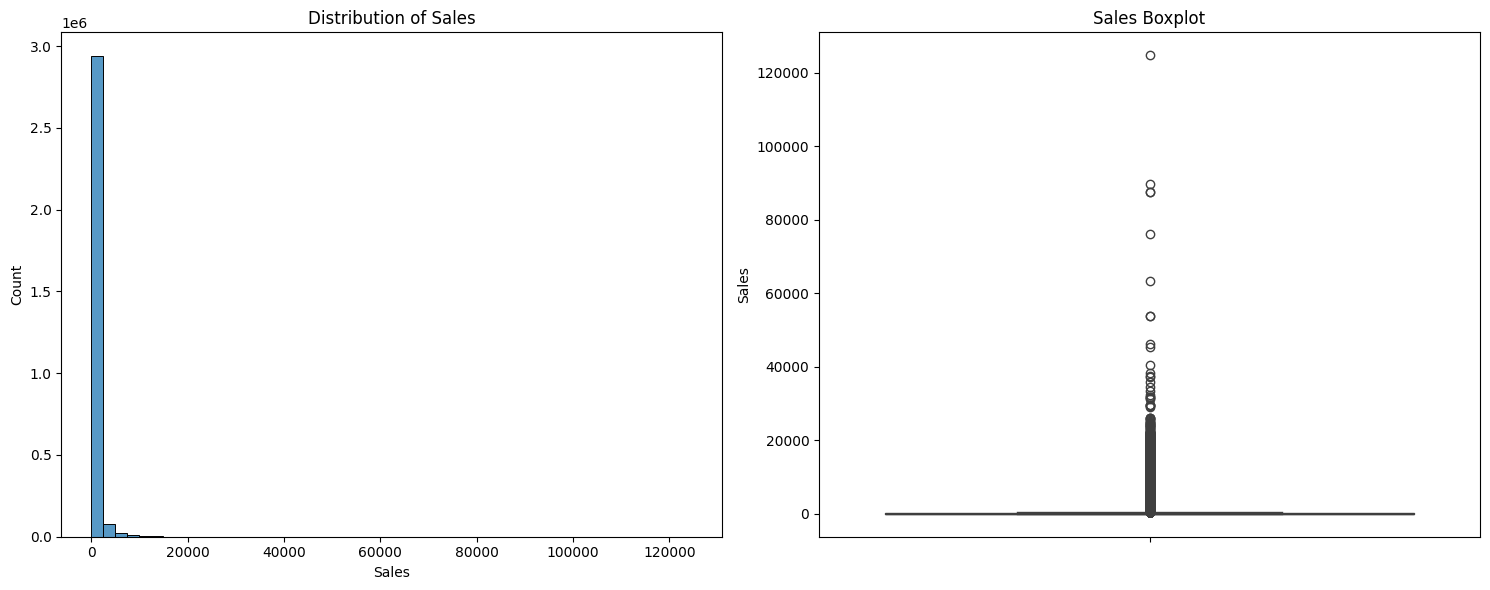

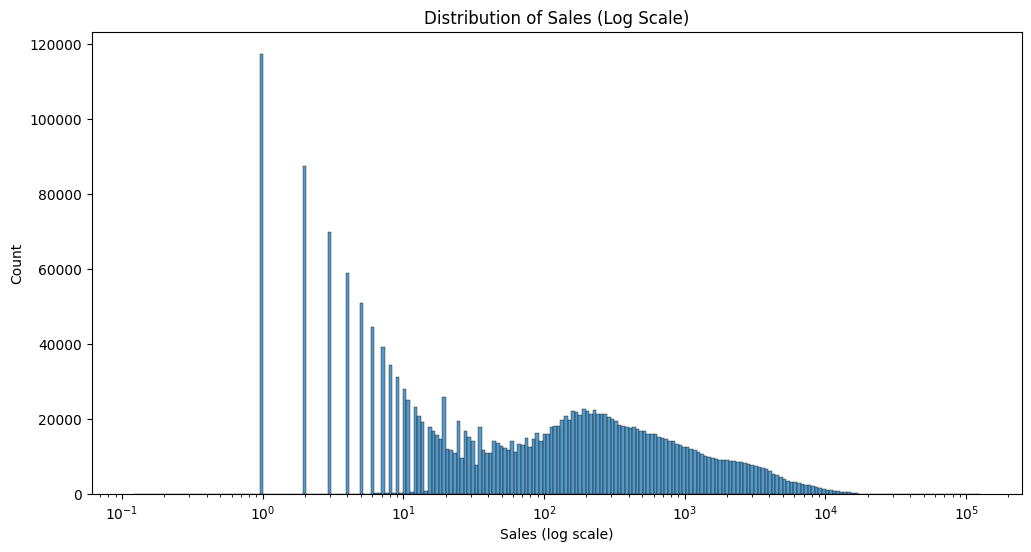

In [100]:
# Sales Distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=train1, x='sales', bins=50)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=train1, y='sales')
plt.title('Sales Boxplot')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()

# Log-transformed sales distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train1[train1['sales'] > 0], x='sales', log_scale=True)
plt.title('Distribution of Sales (Log Scale)')
plt.xlabel('Sales (log scale)')
plt.ylabel('Count')
plt.show()

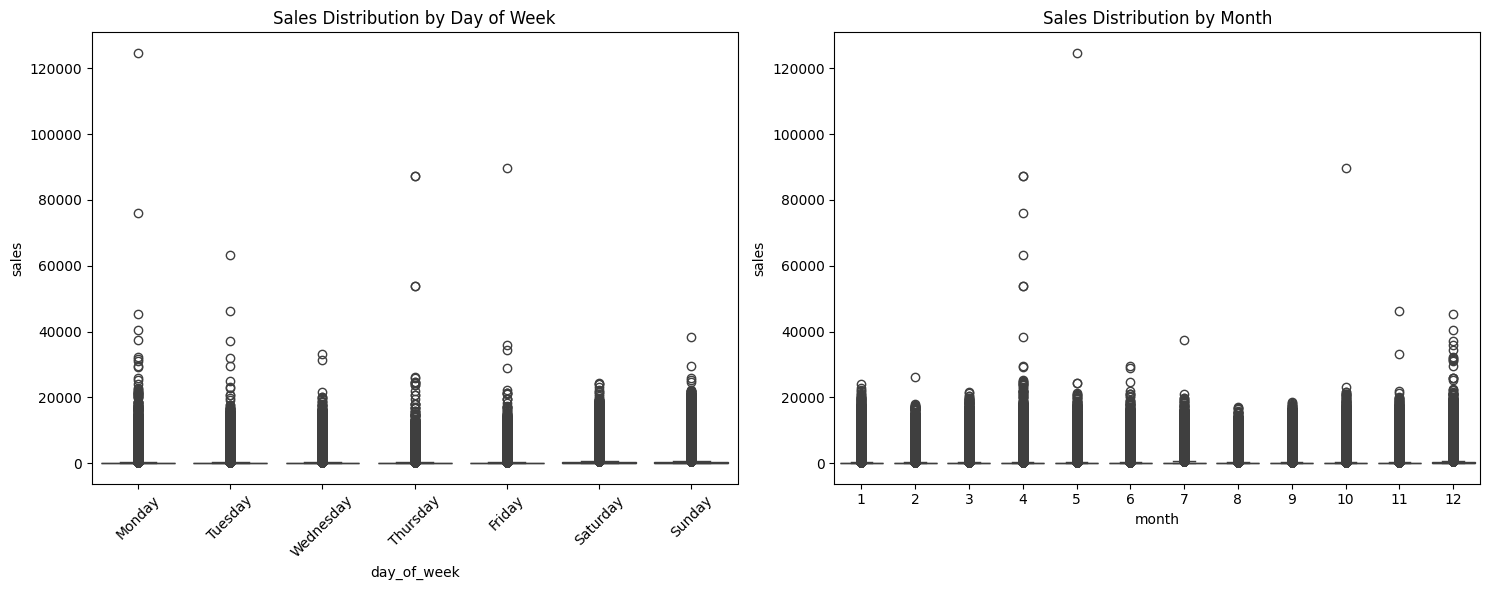

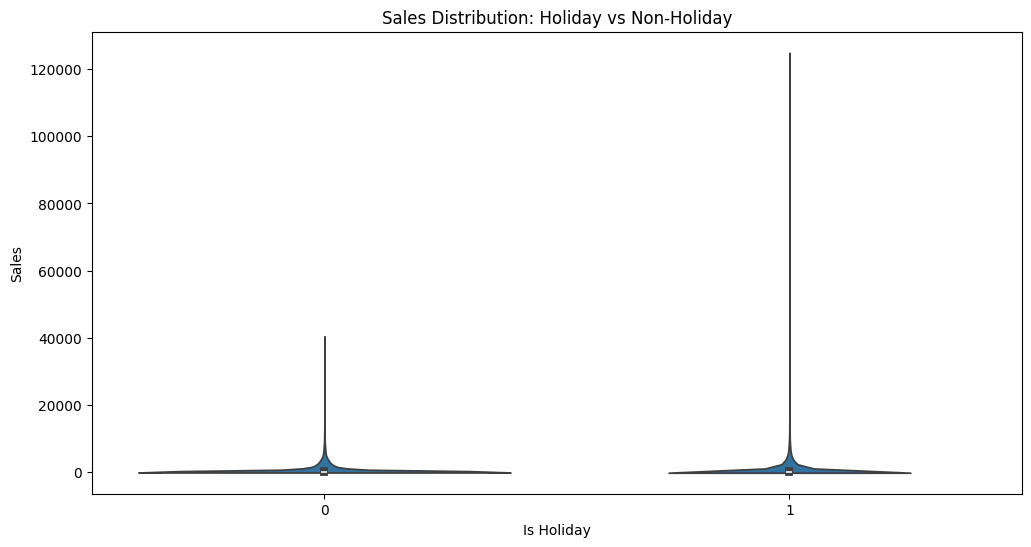

In [103]:
# Sales by Day of Week and Month
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=train1, x='day_of_week', y='sales',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Sales Distribution by Day of Week')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=train1, x='month', y='sales')
plt.title('Sales Distribution by Month')

plt.tight_layout()
plt.show()

# Holiday Effect
plt.figure(figsize=(12, 6))
sns.violinplot(data=train1, x='is_holiday', y='sales')
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

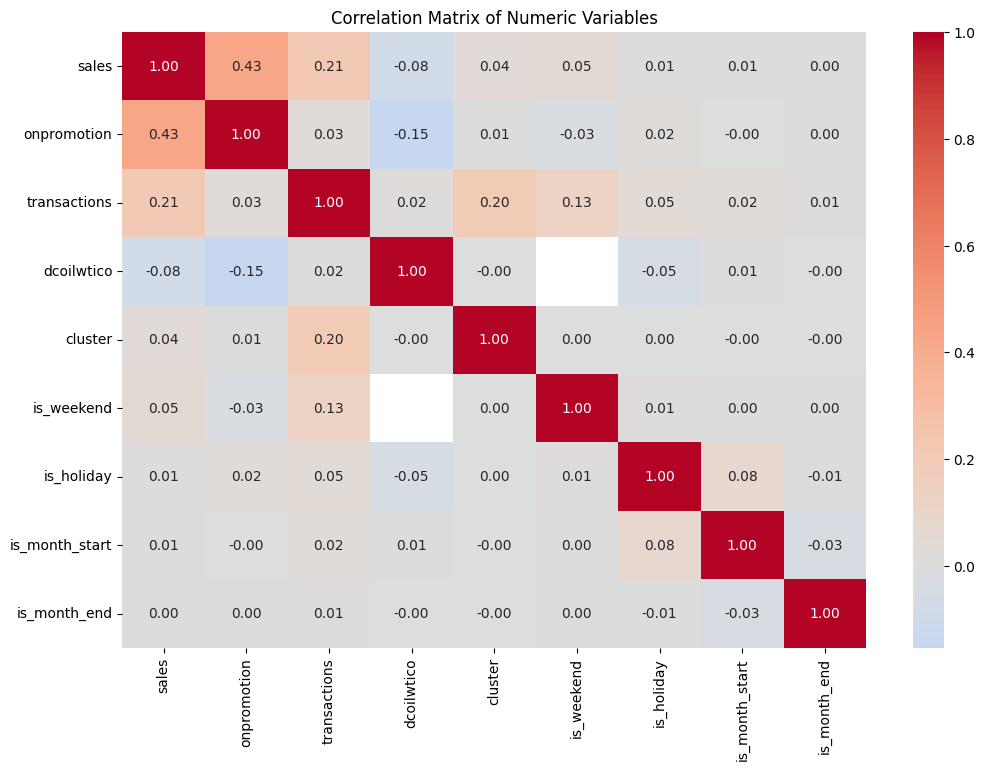

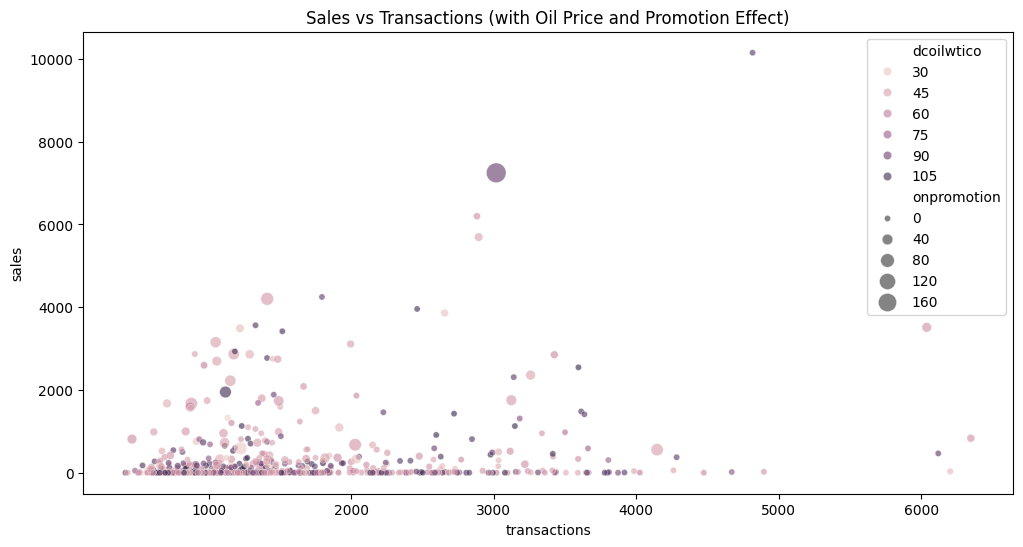

In [102]:
# Correlation Matrix
numeric_cols = ['sales', 'onpromotion', 'transactions', 'dcoilwtico', 
                'cluster', 'is_weekend', 'is_holiday', 'is_month_start', 'is_month_end']
correlation_matrix = train1[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

# Sales vs Transactions with Oil Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train1.sample(1000), x='transactions', y='sales', 
                hue='dcoilwtico', size='onpromotion',
                sizes=(20, 200), alpha=0.6)
plt.title('Sales vs Transactions (with Oil Price and Promotion Effect)')
plt.show()

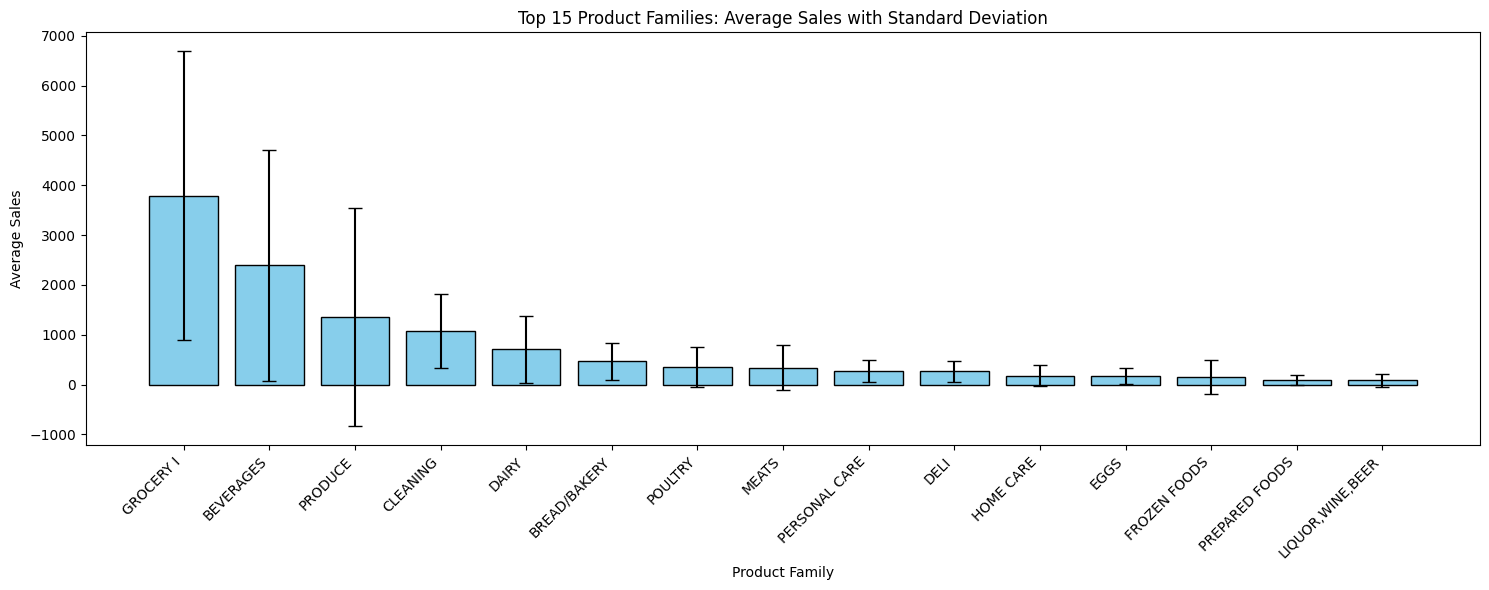

In [106]:
family_metrics = train1.groupby('family').agg({
    'sales': ['mean', 'std'],
    'onpromotion': 'mean'
}).reset_index()

family_metrics.columns = ['family', 'avg_sales', 'std_sales', 'avg_promo']
family_metrics = family_metrics.sort_values('avg_sales', ascending=False)

top_families = family_metrics.head(15)

plt.figure(figsize=(15, 6))
x = range(len(top_families))
plt.bar(x, top_families['avg_sales'], yerr=top_families['std_sales'], 
        capsize=5, color='skyblue', edgecolor='black')
plt.xticks(x, top_families['family'], rotation=45, ha='right')
plt.title('Top 15 Product Families: Average Sales with Standard Deviation')
plt.ylabel('Average Sales')
plt.xlabel('Product Family')
plt.tight_layout()
plt.show()